# Support Vector Machines

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

### Definition

In the section on Bayesian classification we learned a simple model describing the distribution of each underlying class, and used these __generative models__ to probabilistically determine labels for new points.

That was an example of *generative classification*; here we consider __discriminative classification__. Rather than modeling each class, __we simply find a line or curve (in two dimensions) or manifold (in multiple dimensions) that divides the classes from each other.__

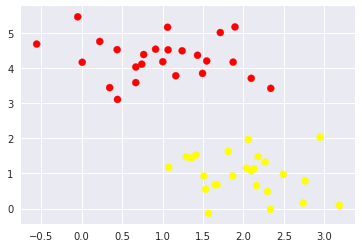

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

__Linear discriminative classifiers__ try to draw a straight line between the two sets of data. We've already got a problem: there is __more than one possible dividing line__ that can discriminate between the two classes.

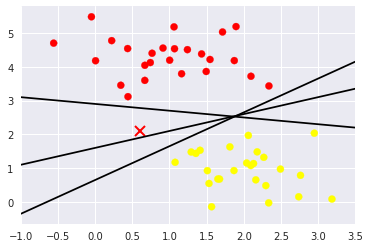

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are three different yet valid eparators. Depending on which you choose, a new data point (marked by the "X") will be assigned a different label.

### Maximizing the *Margin*

SVMs offer an improved method. Instead of simply drawing a zero-width line between the classes, it draws each line with a *margin* of some width, up to the nearest point.

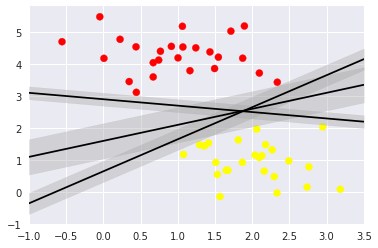

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none', color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

__The line that maximizes this margin is the the optimal model__. SVMs are an example of a *maximum margin* estimator.

### Fitting a support vector machine

Use Scikit's classifier to train an SVM model on this data. Start with a linear kernel and setting the ``C`` parameter to a very large number (more on this in a moment).

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Create a convenience function that plots SVM decision boundaries.

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

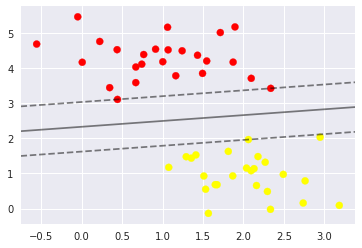

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

Note: a few of the training points touch the margin. __These points are the pivotal elements of this fit, and are known as the *support vectors*, and give the algorithm its name__. Scikit stores these points in the ``support_vectors_`` attribute.

In [8]:
model.support_vectors_

array([[ 0.44359863,  3.11530945],
       [ 2.33812285,  3.43116792],
       [ 2.06156753,  1.96918596]])

__Only the position of the support vectors matter__. Any points further from the margin which are on the correct side do not modify the fit. 

Technically, this is because these points do not contribute to the __loss function__ used to fit the model. Their position and number do not matter so long as they do not cross the margin.

We can see this if we plot the model learned from the first 60 points and first 120 points of this dataset:

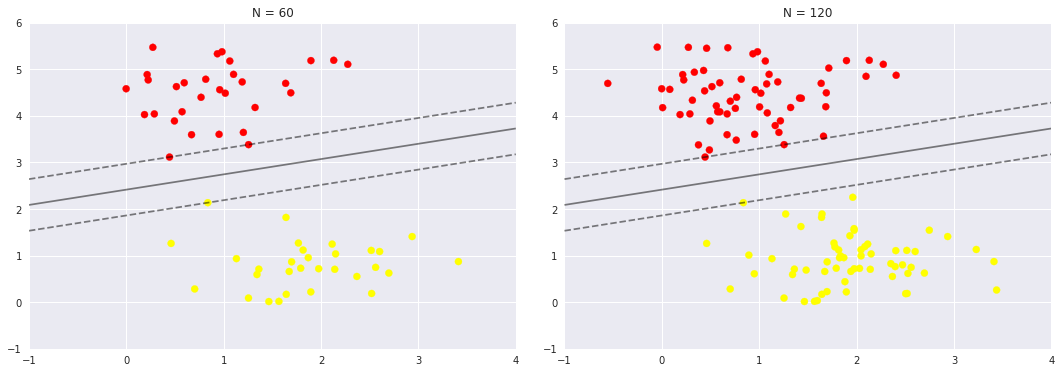

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

__left panel__: the model and support vectors for 60 training points.
__right panel__: 120 training points, but the model has not changed. (This insensitivity to the behavior of distant points is one of the strengths of the SVM model.)

### Beyond linear boundaries: Kernel SVM

SVM becomes extremely powerful is when combined with *kernels*. 

We previously used kernels to project data into higher-dimensional spaces (polynomials and Gaussian basis functions.) Kernel SVM models use the same concept.

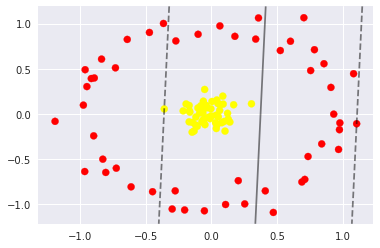

In [10]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

A linear discrimination will __never__ separate this data. But we can try to project the data into a higher dimension such that a linear separator *would* be sufficient. For example, we could use a __radial basis function__ centered on the middle clump:

In [11]:
r = np.exp(-(X ** 2).sum(1))

The difference becomes apparent in a 3D plot.

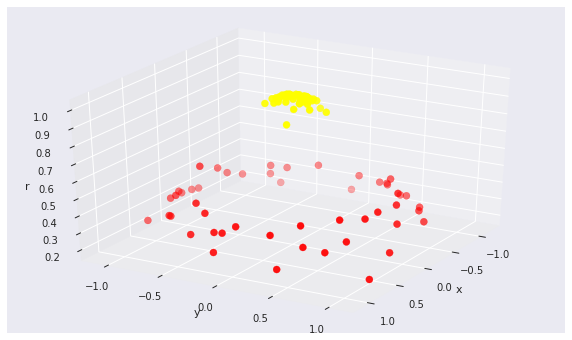

In [17]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    plt.figure(figsize=(10,6))
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

#interact(plot_3D, elev=[-90, 90], azip=(-180, 180), X=fixed(X), y=fixed(y));
plot_3D()

### The Kernel Trick

Now we can see __this data is linearly separable by drawing a separating plane at, say, *r*=0.7.__

Had we had not centered our radial basis function in the right spot, we would not have seen such clean, linearly separable results. __The need to make such a choice is a problem: we would like to automatically find the best basis function.__

One solution is to compute a basis function centered at *every* point in the dataset, and let the SVM algorithm sift through the results. __This is known as a kernel transformation__, - it is based on a similarity relationship (or kernel) between __pairs of points__.

This strategy — projecting $N$ points into $N$ dimensions - becomes very computationally intensive as $N$ grows. However, because of a neat procedure known as the [*kernel trick*](https://en.wikipedia.org/wiki/Kernel_trick), a fit on kernel-transformed data can be done implicitly (without building the full $N$-dimensional representation of the kernel projection)!

This kernel trick is built into the SVM. In Scikit we apply kernelized SVM by changing our linear kernel to an RBF (radial basis function) kernel, using the ``kernel`` model hyperparameter:

In [18]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

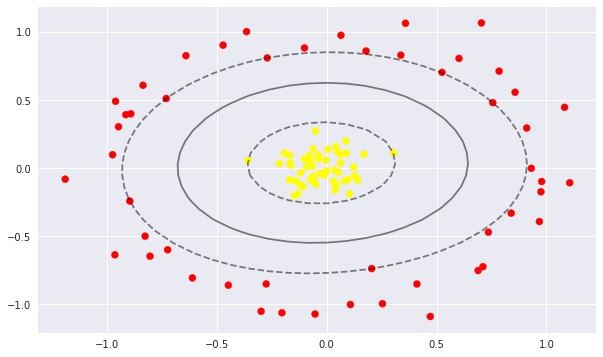

In [19]:
plt.figure(figsize=(10,6))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

plot_svc_decision_function(clf)

plt.scatter(
    clf.support_vectors_[:, 0], 
    clf.support_vectors_[:, 1],
    s=300, lw=1, facecolors='none');

Now we have a suitable nonlinear decision boundary. 

Kernel transformations are used often in machine learning __to turn fast linear methods into fast nonlinear methods__, especially for models in which the kernel trick can be used.

### Tuning the SVM: Softening Margins

What if your data has overlap (no perfect decision boundaries)?

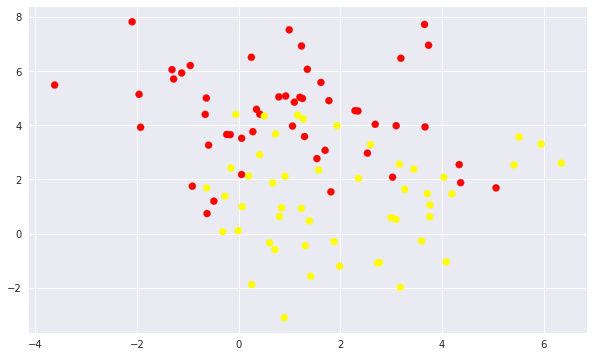

In [20]:
X, y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=1.8)

plt.figure(figsize=(10,6))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

SVM handles this problem with a __parameter $C$. which "softens" the margin__. 

Large $C$ hardens the margin. (No exceptions.) Small $C$ softens the margin. (It can grow to encompass some points.)

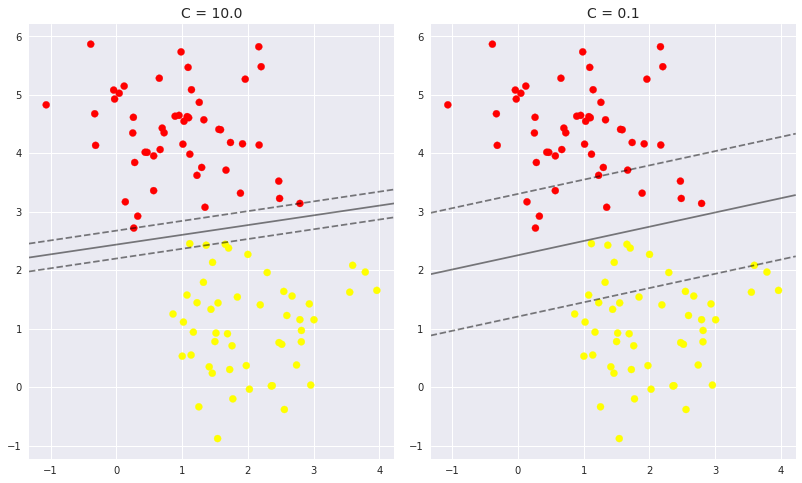

In [21]:
X, y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(12,8))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

The optimal value of $C$ depends on your dataset. __Tune it using cross-validation or a similar procedure.__

### Example: Face Recognition

Use the Labeled Faces in the Wild dataset (several thousand collated photos of various public figures). The dataset fetcher is built into Scikit:

In [22]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Plot the first 15 faces to see examples.

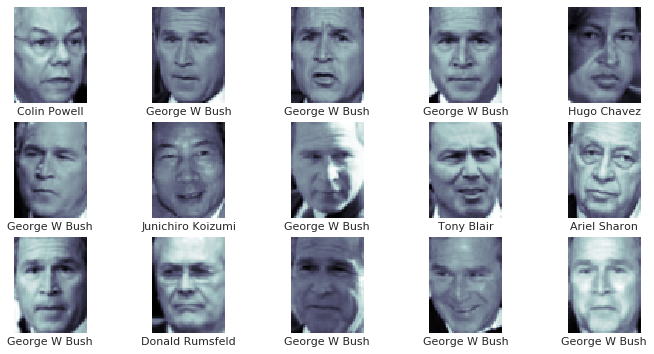

In [35]:
fig, ax = plt.subplots(3, 5, figsize=(12,6))

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Each image contains [62×47] or nearly 3,000 pixels. We could use each pixel value as a feature - it's more effective to use a preprocessor to extract meaningful features.

Use PCA to extract 150 meaningful components to feed into an SVM classifier.

Combine the preprocessor and the classifier into a single pipeline.

In [36]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True, random_state=42, svd_solver='randomized')
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

Split the data into training and testing sets

In [37]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)

Use a grid search CV to explore combinations of parameters. Adjust ``C`` (margin hardness) & ``gamma`` (size of the radial basis function kernel), and determine the best model.

In [38]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}

grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 1min 11s, sys: 1.51 s, total: 1min 12s
Wall time: 18.4 s
{'svc__C': 10, 'svc__gamma': 0.001}


The optimal values fall (roughly) toward the middle of our grid. If on the edges, we would want to expand the grid to make sure we have found a true optimum. Now predict the labels for the test data.

In [39]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Review some test images along with their predicted values:

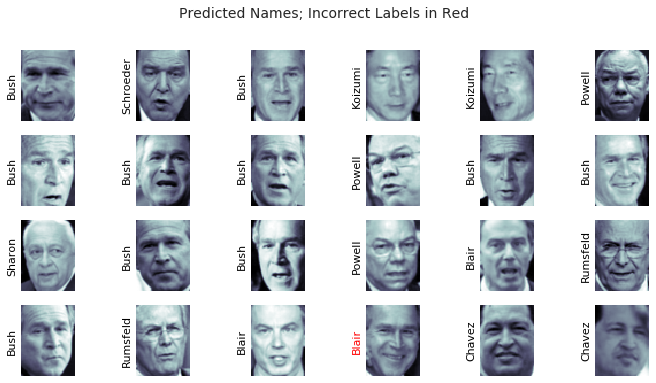

In [40]:
fig, ax = plt.subplots(4, 6, figsize=(12,6))
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Our estimator mislabeled only a single face in this sample. 

__Get a better sense of the estimator's performance using the classification report__, which lists recovery statistics  by label:

__Then generate a confusion matrix__ to see between-class mismatches.

In [41]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

      avg / total       0.86      0.85      0.85       337



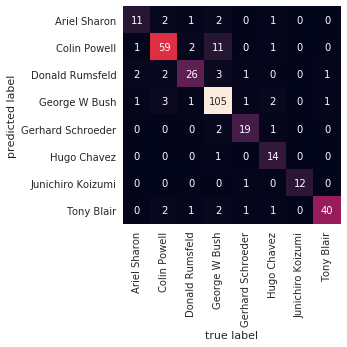

In [42]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

__Real-world facial recognition photos do not come pre-cropped into nice grids__. You need a more sophisticated algorithm to find faces and extract features that are independent of the pixellation.

__Consider using [OpenCV](http://opencv.org)__ It includes pre-trained implementations of state-of-the-art feature extraction tools for images in general and faces in particular.

### Support Vector Machine Summary

__Advantages__:

- Their dependence on relatively few support vectors means that they are very compact models, and take up very little memory.
- Once the model is trained, the prediction phase is very fast.
- Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is a challenging regime for other algorithms.
- Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

__Disadvantages__:

- scaling $N$ is $\mathcal{O}[N^3]$ at worst, or $\mathcal{O}[N^2]$ for efficient implementations. For large numbers of training samples, the computational cost can be prohibitive.
- The results are strongly dependent on the softening parameter $C$. This should be chosen via cross-validation, which can be expensive as datasets grow in size.
- The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the ``probability`` parameter of ``SVC``), but this extra estimation is costly.
- Use SVMs once other simpler, faster, and less tuning-intensive methods are proven to be insufficient. If you have the CPU budget to tolerate the training and cross-validating workload, SVMs can lead to excellent results.